# 1. 방법론

- 데이터의 비율(test data와 train data의 비율)을 조정하거나, n_neighbor의 수를 조정해서 최대한 높은 정확도가 나오는 것을 추출해보자.



# 2. 데이터 라벨링

절대 모멘텀과 비슷하게 가기 위해, 세는 데이터의 단위를 1일이 아니라 1달로 한다.

# 3. 데이터 불러오기(데이터 범위 수정)

In [1]:
import numpy as np
import pandas as pd
import datetime #날짜를 계산하기 위해 import 한다.

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from pandas_datareader import data as pdr #Yahoo Finance으로부터 데이터를 불러오기 위한 패키지



In [2]:
#yfinance를 이용해서 데이터를 불러오자.

import yfinance as yf

#symbol, start date, end date를 지정한다.
#만약 다른 데이터를 불러오고 싶다면, spy 대신 gld(금)나 tlt(미국 국채 20)등 다른 티커명을 입력하자.

#start_date나 end_date를 조작해서 다양한 기간에 따른 결과를 얻어보자.
symbol = 'SPY'
start_date = '1993-01-01'
end_date = '2023-11-21'


df = yf.download(symbol,start=start_date,end=end_date)


#데이터 불러오기

print(df)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   24.941387   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.118790   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.171993   
1993-02-03   44.406250   44.843750   44.375000   44.812500   25.438093   
1993-02-04   44.968750   45.093750   44.468750   45.000000   25.544527   
...                ...         ...         ...         ...         ...   
2023-11-14  446.320007  450.059998  446.089996  448.730011  448.730011   
2023-11-15  450.109985  451.380005  448.799988  449.679993  449.679993   
2023-11-16  449.220001  450.559998  448.119995  450.230011  450.230011   
2023-11-17  450.239990  451.420013  449.290009  450.790009  450.790009   
2023-11-20  450.529999  455.130005  450.519

In [3]:
#na 데이터를 지우고, 데이터를 확인한다.

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.941387,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.118790,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.171993,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.438093,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.544527,531500


In [4]:
#필요한 데이터만 골라 다른 배열에 저장한다.
#이름을 df1으로 저장한다.
df1 = df[['Open','High','Low','Close','Adj Close']].copy()

#시가와 종가의 차이/ 최고가와 최저가의 차이를 구한다.

df1['gap-OpenClose'] = df1['Open'] - df1['Close']
df1['gap-HighLow'] = df1['High'] - df1['Low']
df1 = df1.dropna() #중간중간에 결측치를 제거한다.

#X,Y를 정의한다. X에는 시가와 종가의 차이, 고가와 저가의 차이를 저장하고,
#Y는 주가의 오름과 내림을 정의한다. 다음날의 종가가 다음날의 시가보다 크다면1, 아니면 -1이다.
#시가, 종가를 평가할 때, shift를 통해 행을 올린다.
X = df1[['gap-OpenClose','gap-HighLow','Adj Close','Open','High','Low','Close']]
Y = np.where(df1['Close'].shift(-1) > df1['Open'].shift(-1), 1, -1)


X.head()

,gap-OpenClose,gap-HighLow,Adj Close,Open,High,Low,Close
Date,,,,,,,
1993-01-29,0.03125,0.21875,24.941387,43.96875,43.96875,43.75000,43.93750
1993-02-01,-0.28125,0.28125,25.118790,43.96875,44.25000,43.96875,44.25000
1993-02-02,-0.12500,0.25000,25.171993,44.21875,44.37500,44.12500,44.34375
1993-02-03,-0.40625,0.46875,25.438093,44.40625,44.84375,44.37500,44.81250
1993-02-04,-0.03125,0.62500,25.544527,44.96875,45.09375,44.46875,45.00000


# 4. 데이터 라벨링 

In [5]:
#1일 단위를 1달 단위로 바꾼다.
#이 코드는 다시 실행하면 안된다.

#reset_index를 통해 date를 index로 바꾼다.
X = X.reset_index(drop = False)


# Assuming X is your DataFrame with a 'Date' column
X['Date'] = pd.to_datetime(X['Date'])  # Convert 'Date' to datetime if not already done

# Create the 'year_month' column using the 'Date' column
X['year_month'] = X['Date'].dt.strftime('%Y-%m')

month_list = X['year_month'].unique() #month들의 list를 구한다.
X.head()

,Date,gap-OpenClose,gap-HighLow,Adj Close,Open,High,Low,Close,year_month
0,1993-01-29,0.03125,0.21875,24.941387,43.96875,43.96875,43.75000,43.93750,1993-01
1,1993-02-01,-0.28125,0.28125,25.118790,43.96875,44.25000,43.96875,44.25000,1993-02
2,1993-02-02,-0.12500,0.25000,25.171993,44.21875,44.37500,44.12500,44.34375,1993-02
3,1993-02-03,-0.40625,0.46875,25.438093,44.40625,44.84375,44.37500,44.81250,1993-02
4,1993-02-04,-0.03125,0.62500,25.544527,44.96875,45.09375,44.46875,45.00000,1993-02


In [6]:
import pandas as pd

#위의 데이터를 월말에 있는 데이터만 골라서 따로 정의한다.

month_list_df = pd.DataFrame()  # Create a new DataFrame

month_last_days = []  # Define an empty list

for m in month_list:  # Iterate through month_list
    # Find the last day index for the given year_month
    last_day_index = X[X['year_month'] == m].index[-1]
    # Append the row corresponding to the last day to the list
    month_last_days.append(X.loc[[last_day_index], :])

# Concatenate the rows in the list to create the new DataFrame
month_list_df = pd.concat(month_last_days)

# Set the 'Date' column as the index
month_list_df.set_index(['Date'], inplace=True)

# Display the first few rows of the resulting DataFrame
print(month_list_df.head())

            gap-OpenClose  gap-HighLow  Adj Close      Open      High  \
Date                                                                    
1993-01-29        0.03125      0.21875  24.941387  43.96875  43.96875   
1993-02-26        0.03125      0.25000  25.207491  44.43750  44.43750   
1993-03-31        0.15625      0.28125  25.772099  45.34375  45.46875   
1993-04-30        0.09375      0.25000  25.112665  44.12500  44.28125   
1993-05-28        0.18750      0.40625  25.789934  45.40625  45.40625   

                 Low     Close year_month  
Date                                       
1993-01-29  43.75000  43.93750    1993-01  
1993-02-26  44.18750  44.40625    1993-02  
1993-03-31  45.18750  45.18750    1993-03  
1993-04-30  44.03125  44.03125    1993-04  
1993-05-28  45.00000  45.21875    1993-05  


In [7]:
month_list_df.head()

,gap-OpenClose,gap-HighLow,Adj Close,Open,High,Low,Close,year_month
Date,,,,,,,,
1993-01-29,0.03125,0.21875,24.941387,43.96875,43.96875,43.75000,43.93750,1993-01
1993-02-26,0.03125,0.25000,25.207491,44.43750,44.43750,44.18750,44.40625,1993-02
1993-03-31,0.15625,0.28125,25.772099,45.34375,45.46875,45.18750,45.18750,1993-03
1993-04-30,0.09375,0.25000,25.112665,44.12500,44.28125,44.03125,44.03125,1993-04
1993-05-28,0.18750,0.40625,25.789934,45.40625,45.40625,45.00000,45.21875,1993-05


In [8]:
#1달 간격의 종가간의 차이를 구한다.

month_list_df['1monthsAgo_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
month_list_df['GapOf1Month']=month_list_df['Adj Close']-month_list_df['1monthsAgo_Adj Close']
month_list_df.fillna(0,inplace=True)

In [9]:
month_list_df.head()

,gap-OpenClose,gap-HighLow,Adj Close,Open,High,Low,Close,year_month,1monthsAgo_Adj Close,GapOf1Month
Date,,,,,,,,,,
1993-01-29,0.03125,0.21875,24.941387,43.96875,43.96875,43.75000,43.93750,1993-01,0.000000,0.000000
1993-02-26,0.03125,0.25000,25.207491,44.43750,44.43750,44.18750,44.40625,1993-02,24.941387,0.266104
1993-03-31,0.15625,0.28125,25.772099,45.34375,45.46875,45.18750,45.18750,1993-03,25.207491,0.564608
1993-04-30,0.09375,0.25000,25.112665,44.12500,44.28125,44.03125,44.03125,1993-04,25.772099,-0.659433
1993-05-28,0.18750,0.40625,25.789934,45.40625,45.40625,45.00000,45.21875,1993-05,25.112665,0.677269


In [10]:
#1달간의 종가 차이가 +이면 1로 저장, -이면 -1로 저장한다.

X=month_list_df[['gap-OpenClose','gap-HighLow']]
Y=np.where(month_list_df['GapOf1Month'].shift(-1) > 0,1, -1)


# 3. 데이터 분리, 모델 학습



In [11]:
split_ratio = 0.9
split = int(split_ratio*len(month_list_df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]



#knn 학습

#for 반복문을 통해 1~15까지의 k값을 가진 모델을 만들어본다.
#학습을 하는데 KNeighborsClassifier을 가져온다.
#중요 개념: n_neighbors는 학습을 시킬 때 인접한 샘플의 수이다.즉, 이 숫자가 높을 수록 인접한 샘플의 수가 늘어난다. 
#train데이터와 test데이터의 배열을 정의한다.
train_acc=[]
test_acc=[]

for i in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=i) #이 함수를 통해 모델을 훈련시킨다.
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, Y_train)) #각각의 정확도들을 train_acc에 추가한다.
    test_acc.append((prediction==Y_test).mean())
    



# 4. 결과 그래프로 만들기, 결과 산출



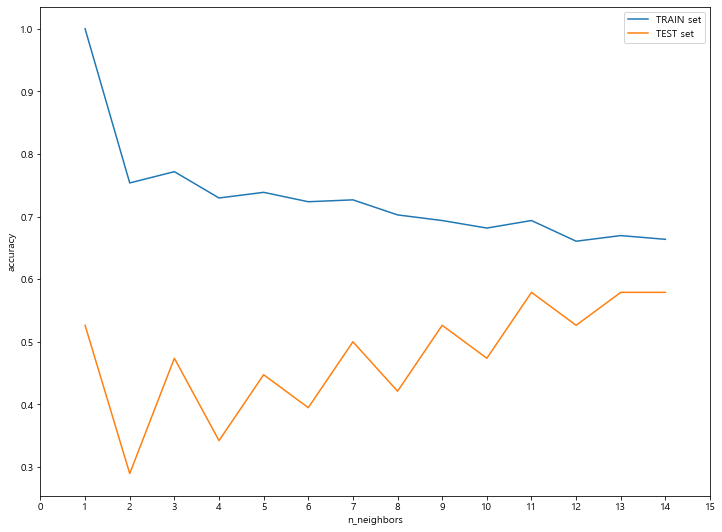

In [12]:
plt.figure(figsize=(12,9))
plt.plot(range(1,15),train_acc,label='TRAIN set') #train set에 대한 선을 긋는다.
plt.plot(range(1,15),test_acc,label='TEST set') #test set에 대한 선을 긋는다.
plt.xlabel("n_neighbors") #x축에 제목을 붙인다.
plt.ylabel("accuracy") #y축에 제목을 붙인다.
plt.xticks(np.arange(0,16,step=1))
plt.legend()

In [13]:
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train,Y_train) #13으로 설정하고 학습을 시킨다.


#수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 

print('훈련 정확도 : %.2f' % accuracy_train + '%') 
print('테스트 정확도 : %.2f' % accuracy_test + '%')

훈련 정확도 : 66.97%
테스트 정확도 : 57.89%


In [14]:
#정확도를 저장하는 리스트를 만들자.

accuracy_test_list =[]

for n in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train,Y_train) #9로 설정하고 학습을 시킨다.
        #수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
        accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
        accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 

        print('훈련 정확도 : %.2f' % accuracy_train) 
        print('테스트 정확도 : %.2f' % accuracy_test)
        accuracy_test_list.append(accuracy_test)

훈련 정확도 : 100.00
테스트 정확도 : 52.63
훈련 정확도 : 75.38
테스트 정확도 : 28.95
훈련 정확도 : 77.18
테스트 정확도 : 47.37
훈련 정확도 : 72.97
테스트 정확도 : 34.21
훈련 정확도 : 73.87
테스트 정확도 : 44.74
훈련 정확도 : 72.37
테스트 정확도 : 39.47
훈련 정확도 : 72.67
테스트 정확도 : 50.00
훈련 정확도 : 70.27
테스트 정확도 : 42.11
훈련 정확도 : 69.37
테스트 정확도 : 52.63
훈련 정확도 : 68.17
테스트 정확도 : 47.37
훈련 정확도 : 69.37
테스트 정확도 : 57.89
훈련 정확도 : 66.07
테스트 정확도 : 52.63
훈련 정확도 : 66.97
테스트 정확도 : 57.89
훈련 정확도 : 66.37
테스트 정확도 : 57.89


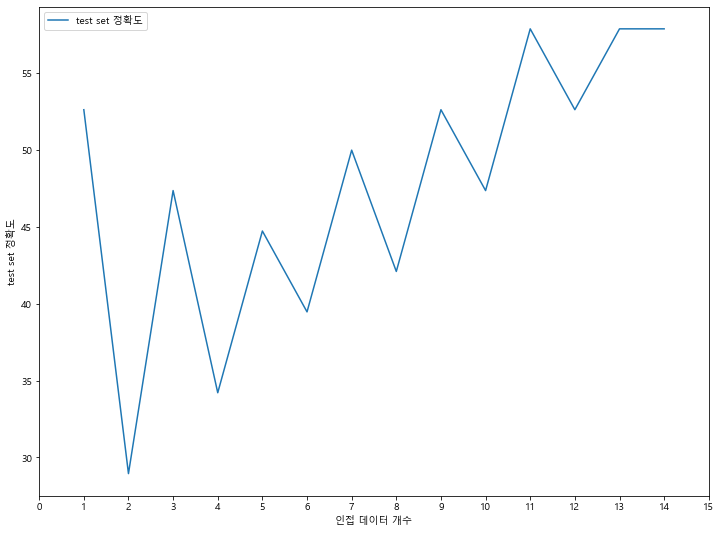

In [15]:
#test set의 정확도만 따로 산출해서 그린다.

plt.figure(figsize=(12,9))
plt.plot(range(1,15),accuracy_test_list,label='test set 정확도') 
plt.xlabel('인접 데이터 개수') #x축에 제목을 붙인다.
plt.ylabel("test set 정확도") #y축에 제목을 붙인다.
plt.xticks(np.arange(0,16,step=1))
plt.legend()

# 5. 결과 산출

데이터를 1달 단위로 바꾸고, knn을 실행한 결과, k의 개수가 11일 때 최고의 정확도 (약 58프로)를 보인다.(ratio:0.7)


그런데, 58프로의 정확도로는 데이터 분석을 하기에 약간 모자라 보인다. 

그래서, split_ratio를 바꾸거나, 데이터의 기간을 바꿀 것이다.

# 6.위의 코드들을 함수로 묶기

In [16]:
#데이터 프레임을 만드는 함수. 위에서 만들었던 함수들을 따 온것이므로 
#설명은 가능한한 생략했다.

def makedata(symbol,start_date,end_date):
    df = yf.download(symbol,start=start_date,end=end_date)
    df = df.dropna()
    
    df1 = df[['Open','High','Low','Close','Adj Close']].copy()
    df1['gap-OpenClose'] = df1['Open'] - df1['Close']
    df1['gap-HighLow'] = df1['High'] - df1['Low']
    df1 = df1.dropna() 
    
    X = df1[['gap-OpenClose','gap-HighLow','Adj Close','Open','High','Low','Close']]
    Y = np.where(df1['Close'].shift(-1) > df1['Open'].shift(-1), 1, -1)
    
  
    X = X.reset_index(drop = False)
    X['Date'] = pd.to_datetime(X['Date']) 
    X['year_month'] = X['Date'].dt.strftime('%Y-%m')
    month_list = X['year_month'].unique() 
    
    month_list_df = pd.DataFrame()
    month_last_days = []
    
    for m in month_list:
        last_day_index = X[X['year_month'] == m].index[-1]
        month_last_days.append(X.loc[[last_day_index], :])
    month_list_df = pd.concat(month_last_days) 
    month_list_df.set_index(['Date'], inplace=True)

    month_list_df['1monthsAgo_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
    month_list_df['GapOf1Month']=month_list_df['Adj Close']-month_list_df['1monthsAgo_Adj Close']
    month_list_df.fillna(0,inplace=True)
    
    X=month_list_df[['gap-OpenClose','gap-HighLow']]
    Y=np.where(month_list_df['GapOf1Month'].shift(-1) > 0,1, -1)
    
    
    print("making DataFrame Complete.")

In [22]:
#데이터를 분리,이웃하는 수들을 정하는 함수

def splitAndTrain(split_ratio,n):
    split_ratio=split_ratio
    split = int(split_ratio*len(month_list_df))

    X_train = X[:split]
    Y_train = Y[:split]

    X_test = X[split:]
    Y_test = Y[split:]



    #knn 학습

    #for 반복문을 통해 1~15까지의 k값을 가진 모델을 만들어본다.
    #학습을 하는데 KNeighborsClassifier을 가져온다.
    #중요 개념: n_neighbors는 학습을 시킬 때 인접한 샘플의 수이다.즉, 이 숫자가 높을 수록 인접한 샘플의 수가 늘어난다. 
    #train데이터와 test데이터의 배열을 정의한다.
    train_acc=[]
    test_acc=[]

    for i in range(1,n):
        clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=i) #이 함수를 통해 모델을 훈련시킨다.
        clf.fit(X_train, Y_train)
        prediction = clf.predict(X_test)
        train_acc.append(clf.score(X_train, Y_train)) #각각의 정확도들을 train_acc에 추가한다.
        test_acc.append((prediction==Y_test).mean())
    
    print("splitAndTrain Complete.")

In [23]:
#결과를 산출하는 함수. 편의상 test set만 출력한다.


def drawGraph(n):
    #최대값 출력 위한 변수
    test_max = 0
    accuracy_test_list =[]
    for i in range(1,n):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,Y_train)
        
        #수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
        accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
        accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 
        if(test_max<=accuracy_test):
            test_max=accuracy_test
        print('훈련 정확도 : %.2f' % accuracy_train) 
        print('테스트 정확도 : %.2f' % accuracy_test)
        accuracy_test_list.append(accuracy_test)
        
        #test set의 정확도만 따로 산출해서 그린다.

    plt.figure(figsize=(12,9))
    plt.plot(range(1,n),accuracy_test_list,label='test set 정확도') 
    plt.xlabel('인접 데이터 개수') #x축에 제목을 붙인다.
    plt.ylabel("test set 정확도") #y축에 제목을 붙인다.
    plt.xticks(np.arange(0,n+1,step=1))
    plt.legend()
    
    print("최대 test set 정확도: ",test_max)

In [17]:
# 함수를 정의했다. 모델 최적화는 다음 파일에서 하도록 하자.